In [4]:
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [61]:
df = pd.read_pickle('absdata.p')

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [8]:
data_words = list(sent_to_words(df['clean_train_abstract']))

bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

data_words_bigrams = make_bigrams(data_words)

id2word = corpora.Dictionary(data_words_bigrams)

texts = data_words_bigrams

# corpus 만듦
corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
# 뽑을 토픽의 개수
num_topics = 15

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=20,
alpha='auto',
per_word_topics=True)

In [10]:
# Compute Perplexity - 낮을수록 좋다
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score - 높을수록 좋다 (0~1사이의 값)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.061886478189313

Coherence Score:  0.3471738127883977


In [11]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [12]:
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [30]:
absTopicTable = pd.DataFrame(index=np.arange(0, len(corpus)),columns=['doc#']+[x for x in range(num_topics)])
absTopicTable.head()

,doc#,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
absTopicTable['doc#'] = absTopicTable.index
absTopicTable.head()

,doc#,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
import time

start = time.time()
count = 0
for doc in corpus:
    if(count%500==0):
        print('~%d times :'%count + str(time.time()-start))
        start = time.time()
    for freq in lda_model.get_document_topics(doc):
        absTopicTable.loc[count,freq[0]] = freq[1]
    count+=1

~0 times :0.00011491775512695312
~500 times :6.917697906494141
~1000 times :6.961647033691406
~1500 times :7.3552491664886475
~2000 times :7.4675610065460205
~2500 times :8.386843204498291
~3000 times :8.06702995300293
~3500 times :8.359332084655762
~4000 times :8.169352293014526
~4500 times :9.556020975112915
~5000 times :9.059150695800781
~5500 times :9.762754917144775
~6000 times :9.680442094802856
~6500 times :9.693698167800903
~7000 times :9.521788120269775
~7500 times :9.47316312789917
~8000 times :9.669555902481079
~8500 times :10.069056034088135
~9000 times :10.457233905792236
~9500 times :10.451128721237183
~10000 times :9.986395835876465
~10500 times :10.063172101974487
~11000 times :9.836001873016357
~11500 times :10.946460962295532
~12000 times :11.503083944320679


In [40]:
# table 저장
probTable_name = 'doc_per_'+str(num_topics)+'Topicprob.p'
absTopicTable.to_pickle(probTable_name)

In [79]:
doc_per_Topicprob = pd.read_pickle(probTable_name)

In [80]:
doc_per_Topicprob = absTopicTable.fillna(0)
doc_per_Topicprob.head()

,doc#,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0.052048,0.027365,0.012717,0.273242,0.010478,0.182539,0.025256,0.092206,0.224110,0.050139,0.000000,0.000000,0.019700,0.010456,0.000000
1,1,0.099084,0.031604,0.027970,0.249785,0.000000,0.067889,0.195411,0.057947,0.117640,0.023233,0.010481,0.022995,0.058296,0.000000,0.023385
2,2,0.060404,0.081026,0.070491,0.239902,0.030331,0.244212,0.000000,0.017931,0.145516,0.000000,0.000000,0.000000,0.000000,0.000000,0.076140
3,3,0.060004,0.037415,0.017683,0.374701,0.000000,0.104526,0.016370,0.187428,0.080528,0.013569,0.033850,0.000000,0.000000,0.024188,0.033903
4,4,0.054716,0.045559,0.010917,0.306138,0.027985,0.039672,0.027470,0.013404,0.269878,0.000000,0.066996,0.025005,0.074135,0.020435,0.011497


In [81]:
df[['pubDate','abstract']].head()

,pubDate,abstract
0,2015-01-01,Traditional data mining usually deals with dat...
1,2015-01-01,The explosive popularity of microblogging serv...
2,2015-07-01,What is a systematic way to efficiently apply ...
3,2015-07-01,Data collection is required to be safe and eff...
4,1900-01-01,Learning based hashing techniques have attract...


In [82]:
doc_per_Topicprob['pubDate'] = df['pubDate']

In [86]:
cols = list(doc_per_Topicprob.columns.values)
cols.insert(1,'pubDate')
cols = cols[:-1]
cols

['doc#', 'pubDate', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [88]:
doc_per_Topicprob[cols].head()

,doc#,pubDate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,2015-01-01,0.052048,0.027365,0.012717,0.273242,0.010478,0.182539,0.025256,0.092206,0.224110,0.050139,0.000000,0.000000,0.019700,0.010456,0.000000
1,1,2015-01-01,0.099084,0.031604,0.027970,0.249785,0.000000,0.067889,0.195411,0.057947,0.117640,0.023233,0.010481,0.022995,0.058296,0.000000,0.023385
2,2,2015-07-01,0.060404,0.081026,0.070491,0.239902,0.030331,0.244212,0.000000,0.017931,0.145516,0.000000,0.000000,0.000000,0.000000,0.000000,0.076140
3,3,2015-07-01,0.060004,0.037415,0.017683,0.374701,0.000000,0.104526,0.016370,0.187428,0.080528,0.013569,0.033850,0.000000,0.000000,0.024188,0.033903
4,4,1900-01-01,0.054716,0.045559,0.010917,0.306138,0.027985,0.039672,0.027470,0.013404,0.269878,0.000000,0.066996,0.025005,0.074135,0.020435,0.011497


In [89]:
doc_per_Topicprob = doc_per_Topicprob[cols]

In [90]:
doc_per_Topicprob.head()

,doc#,pubDate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,2015-01-01,0.052048,0.027365,0.012717,0.273242,0.010478,0.182539,0.025256,0.092206,0.224110,0.050139,0.000000,0.000000,0.019700,0.010456,0.000000
1,1,2015-01-01,0.099084,0.031604,0.027970,0.249785,0.000000,0.067889,0.195411,0.057947,0.117640,0.023233,0.010481,0.022995,0.058296,0.000000,0.023385
2,2,2015-07-01,0.060404,0.081026,0.070491,0.239902,0.030331,0.244212,0.000000,0.017931,0.145516,0.000000,0.000000,0.000000,0.000000,0.000000,0.076140
3,3,2015-07-01,0.060004,0.037415,0.017683,0.374701,0.000000,0.104526,0.016370,0.187428,0.080528,0.013569,0.033850,0.000000,0.000000,0.024188,0.033903
4,4,1900-01-01,0.054716,0.045559,0.010917,0.306138,0.027985,0.039672,0.027470,0.013404,0.269878,0.000000,0.066996,0.025005,0.074135,0.020435,0.011497


**여기서 의문 --> 한 문서에서 비율이 높으면 전체적으로 높아짐. 더하기 말고 다른 걸 해야 할 듯**

In [93]:
doc_per_Topicprob['pubDate'] = pd.to_datetime(doc_per_Topicprob['pubDate'], format='%Y-%m-%d', errors='coerce')

In [94]:
doc_per_Topicprob = doc_per_Topicprob[~ doc_per_Topicprob['pubDate'].isnull()]

In [95]:
Topicprob_from1990 = doc_per_Topicprob[doc_per_Topicprob.pubDate >= pd.to_datetime("1990-01-01")]

In [97]:
Topicprob_from1990.shape

(8824, 17)

In [129]:
sorted_by_date = Topicprob_from1990.sort_values(by='pubDate')
sorted_by_date.head()

,doc#,pubDate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2036,2036,1995-03-01,0.112935,0.040553,0.035430,0.154205,0.055855,0.095377,0.013903,0.024795,0.121261,0.011882,0.277646,0.000000,0.011211,0.014355,0.021329
7321,7321,1995-07-01,0.121635,0.072417,0.056499,0.197874,0.061801,0.150158,0.015205,0.080275,0.146241,0.040475,0.010171,0.012656,0.000000,0.000000,0.021448
7320,7320,1996-04-01,0.048806,0.216870,0.054876,0.335131,0.061383,0.071270,0.000000,0.021310,0.057935,0.000000,0.018889,0.000000,0.000000,0.024916,0.065812
2037,2037,1996-07-01,0.049242,0.088097,0.037721,0.121708,0.067101,0.071120,0.021726,0.137390,0.139380,0.000000,0.149744,0.000000,0.032583,0.000000,0.061104
2038,2038,1997-01-01,0.093597,0.083307,0.040315,0.194348,0.028499,0.105325,0.026789,0.049549,0.103060,0.124742,0.041310,0.017375,0.021700,0.027520,0.042565


In [130]:
sorted_by_date = sorted_by_date.set_index('pubDate', inplace=False)
sorted_by_date.head()

,doc#,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
pubDate,,,,,,,,,,,,,,,,
1995-03-01,2036,0.112935,0.040553,0.035430,0.154205,0.055855,0.095377,0.013903,0.024795,0.121261,0.011882,0.277646,0.000000,0.011211,0.014355,0.021329
1995-07-01,7321,0.121635,0.072417,0.056499,0.197874,0.061801,0.150158,0.015205,0.080275,0.146241,0.040475,0.010171,0.012656,0.000000,0.000000,0.021448
1996-04-01,7320,0.048806,0.216870,0.054876,0.335131,0.061383,0.071270,0.000000,0.021310,0.057935,0.000000,0.018889,0.000000,0.000000,0.024916,0.065812
1996-07-01,2037,0.049242,0.088097,0.037721,0.121708,0.067101,0.071120,0.021726,0.137390,0.139380,0.000000,0.149744,0.000000,0.032583,0.000000,0.061104
1997-01-01,2038,0.093597,0.083307,0.040315,0.194348,0.028499,0.105325,0.026789,0.049549,0.103060,0.124742,0.041310,0.017375,0.021700,0.027520,0.042565


In [136]:
# http://enjoyiot.tistory.com/category/Python 참조
docs_in_year = sorted_by_date.resample(rule='A').size() # rule이 'A'면 annual, 'M'이면 month, 분기별로 판단하는 rule도 존재
docs_in_year

pubDate
1995-12-31      2
1996-12-31      2
1997-12-31      1
1998-12-31      1
1999-12-31      4
2000-12-31      3
2001-12-31     10
2002-12-31      8
2003-12-31     30
2004-12-31    376
2005-12-31    459
2006-12-31    735
2007-12-31    795
2008-12-31    530
2009-12-31    582
2010-12-31    516
2011-12-31    721
2012-12-31    736
2013-12-31    445
2014-12-31    490
2015-12-31    569
2016-12-31    563
2017-12-31    652
2018-12-31    594
Freq: A-DEC, dtype: int64

In [137]:
Topicprob_from2004 = doc_per_Topicprob[doc_per_Topicprob.pubDate >= pd.to_datetime("2004-01-01")]
Topicprob_from2004.shape

(8763, 17)

In [139]:
sorted_by_date = Topicprob_from2004.sort_values(by='pubDate').set_index('pubDate', inplace=False)
sorted_by_date.head()

,doc#,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
pubDate,,,,,,,,,,,,,,,,
2004-01-01,2059,0.093818,0.084080,0.010790,0.220639,0.060519,0.039818,0.000000,0.098470,0.048884,0.000000,0.031624,0.019261,0.016906,0.028803,0.232538
2004-01-01,10557,0.046406,0.095054,0.060149,0.197094,0.023403,0.167161,0.010384,0.081644,0.094669,0.000000,0.134327,0.000000,0.020385,0.012951,0.041913
2004-01-01,10558,0.115512,0.140488,0.015841,0.260516,0.044208,0.160348,0.035786,0.014417,0.073289,0.011953,0.054960,0.000000,0.018924,0.026530,0.023564
2004-01-01,10560,0.092393,0.242334,0.054818,0.238023,0.050936,0.093228,0.014316,0.040882,0.089323,0.012426,0.031767,0.000000,0.013133,0.000000,0.016631
2004-01-01,2048,0.049124,0.024624,0.026886,0.304024,0.051849,0.120027,0.013515,0.047507,0.117430,0.019231,0.015818,0.000000,0.000000,0.000000,0.194540


In [150]:
sorted_by_date = sorted_by_date.drop(columns='doc#')
sorted_by_date.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
pubDate,,,,,,,,,,,,,,,
2004-01-01,0.093818,0.084080,0.010790,0.220639,0.060519,0.039818,0.000000,0.098470,0.048884,0.000000,0.031624,0.019261,0.016906,0.028803,0.232538
2004-01-01,0.046406,0.095054,0.060149,0.197094,0.023403,0.167161,0.010384,0.081644,0.094669,0.000000,0.134327,0.000000,0.020385,0.012951,0.041913
2004-01-01,0.115512,0.140488,0.015841,0.260516,0.044208,0.160348,0.035786,0.014417,0.073289,0.011953,0.054960,0.000000,0.018924,0.026530,0.023564
2004-01-01,0.092393,0.242334,0.054818,0.238023,0.050936,0.093228,0.014316,0.040882,0.089323,0.012426,0.031767,0.000000,0.013133,0.000000,0.016631
2004-01-01,0.049124,0.024624,0.026886,0.304024,0.051849,0.120027,0.013515,0.047507,0.117430,0.019231,0.015818,0.000000,0.000000,0.000000,0.194540


[('based', 0.02816164),
 ('performance', 0.019128002),
 ('application', 0.017271731),
 ('proposed', 0.014877906),
 ('information', 0.013487395),
 ('distributed', 0.013463708),
 ('approach', 0.013140759),
 ('paper', 0.010944276),
 ('show', 0.010650477),
 ('also', 0.010013458)]

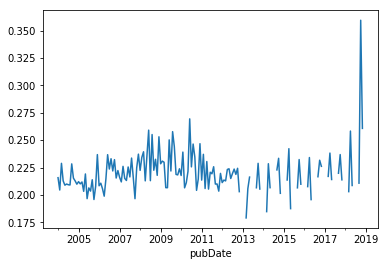

In [185]:
topic_num = 3
sorted_by_date[topic_num].resample('M').mean().plot()
lda_model.show_topic(topic_num)

In [170]:
lda_model.show_topic(3)

[('based', 0.02816164),
 ('performance', 0.019128002),
 ('application', 0.017271731),
 ('proposed', 0.014877906),
 ('information', 0.013487395),
 ('distributed', 0.013463708),
 ('approach', 0.013140759),
 ('paper', 0.010944276),
 ('show', 0.010650477),
 ('also', 0.010013458)]

In [ ]:
sorted_by_date[0].resample('M').mean().plot

In [141]:
import matplotlib.pyplot as plt
# plt.show() 하지 않아도 그래프 그려짐
%matplotlib inline